# Functions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from fastai.tabular.all import *
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, mean_absolute_error
import time
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, precision_score, recall_score, f1_score, 
                             roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

In [5]:
# 0. Daten einlesen
df = pd.read_csv('LoanExport.csv')

/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_11232/1784328241.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanExport.csv')


In [6]:
# 1. Datenvorverarbeitung
def data_preprocessing(df):
    # Unnötige Spalten entfernen
    df.drop(["PropertyState", "PostalCode", "LoanSeqNum", "ServicerName", 'SellerName'], axis=1, inplace=True)

    # Fehlende Werte im gesamten DataFrame behandeln
    # Ersetze 'X' durch np.nan und entferne führende/folgende Leerzeichen für alle spalten
    for column in df.columns:
        df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
        df[column] = df[column].replace('X', np.nan)

        # Ersetze '0' durch np.nan für alle Spalten außer 'EverDelinquent' und 'MonthsDelinquent'
        if column not in ['EverDelinquent', 'MonthsDelinquent']:
                df[column] = df[column].replace(0, np.nan)

    return df

In [7]:
# 2. Zielvariable für den ML-Ansatz erstellen
def create_target_variable(df):
    df['Prepayment'] = df.apply(lambda row: 0 if row['MonthsInRepayment'] < (0.3 * row['OrigLoanTerm']) else 1, axis=1)
    print(df['Prepayment'].value_counts())
    return df

In [8]:
# 3. Datenaufteilung in Trainings-, Validierungs- und Testdatensatz
def split_data(df):
    # Initialize StratifiedShuffleSplit for 80/20 split (training and temporary)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=25)
    for train_index, temp_index in sss.split(df, df['Prepayment']):
        train_df = df.iloc[train_index]
        temp_df = df.iloc[temp_index]
    
    # Initialize StratifiedShuffleSplit for 50/50 split of the temporary set (validation and testing)
    sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=25)
    for val_index, test_index in sss_temp.split(temp_df, temp_df['Prepayment']):
        val_df = temp_df.iloc[val_index]
        test_df = temp_df.iloc[test_index]
    
    return train_df, val_df, test_df

In [9]:
# 4. Daten reinigung mit dType umstellung
def impute_missing_values(train_df, val_df, test_df):
    # Kopien der DataFrames erstellen, um SettingWithCopyWarning zu vermeiden
    train_df = train_df.copy()
    val_df = val_df.copy()
    test_df = test_df.copy()

    # Listen für numerische und kategoriale Spalten erstellen
    num_columns = []
    lit_columns = []

    # Spalten klassifizieren
    for column in train_df.columns:
        non_nan_values = train_df[column].dropna().unique()
        if all(isinstance(value, (int, float)) for value in non_nan_values):
            num_columns.append(column)
        else:
            try:
                # Überprüfen, ob die Werte numerisch sind, auch wenn sie als Strings vorliegen
                [float(value) for value in non_nan_values if value != '']
                num_columns.append(column)
            except ValueError:
                lit_columns.append(column)

    # Numerische Spalten mit dem Median imputieren
    if num_columns:
        num_imputer = SimpleImputer(strategy='median')
        train_df[num_columns] = num_imputer.fit_transform(train_df[num_columns])
        val_df[num_columns] = num_imputer.transform(val_df[num_columns])
        test_df[num_columns] = num_imputer.transform(test_df[num_columns])

    # Kategoriale Spalten mit dem häufigsten Wert imputieren
    if lit_columns:
        lit_imputer = SimpleImputer(strategy='most_frequent')
        train_df[lit_columns] = lit_imputer.fit_transform(train_df[lit_columns])
        val_df[lit_columns] = lit_imputer.transform(val_df[lit_columns])
        test_df[lit_columns] = lit_imputer.transform(test_df[lit_columns])

    # Datentypen für kategoriale Spalten anpassen
    for column in lit_columns:
        train_df[column] = train_df[column].astype('object')
        val_df[column] = val_df[column].astype('object')
        test_df[column] = test_df[column].astype('object')

    # Datentypen für numerische Spalten anpassen
    for column in num_columns:
        def adjust_dtype(value):
            if isinstance(value, str) and '.' in value:
                return float(value)
            elif isinstance(value, (int, float)):
                return value
            else:
                return np.nan

        train_df[column] = train_df[column].apply(adjust_dtype)
        val_df[column] = val_df[column].apply(adjust_dtype)
        test_df[column] = test_df[column].apply(adjust_dtype)

        # Datentyp auf Integer setzen, wenn keine Dezimalstellen vorhanden sind, sonst auf Float
        if all(isinstance(x, (int, np.integer)) or pd.isna(x) for x in train_df[column]):
            train_df[column] = train_df[column].astype('Int64')
            val_df[column] = val_df[column].astype('Int64')
            test_df[column] = test_df[column].astype('Int64')
        else:
            train_df[column] = train_df[column].astype('float64')
            val_df[column] = val_df[column].astype('float64')
            test_df[column] = test_df[column].astype('float64')

    return train_df, val_df, test_df

In [10]:
# 5. Kategorische Spalten remappen mit OneHotEncoder
def encode_categorical_columns(train_df, val_df, test_df):
    # Select columns with dtype 'object'
    cat_columns = train_df.select_dtypes(include=['object']).columns
    
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit the encoder on the training data and transform all sets
    train_encoded = encoder.fit_transform(train_df[cat_columns])
    val_encoded = encoder.transform(val_df[cat_columns])
    test_encoded = encoder.transform(test_df[cat_columns])
    
    # Create DataFrames from the encoded data
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(cat_columns), index=train_df.index)
    val_encoded_df = pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out(cat_columns), index=val_df.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(cat_columns), index=test_df.index)
    
    # Drop original categorical columns and concatenate the new encoded columns
    train_df = pd.concat([train_df.drop(columns=cat_columns), train_encoded_df], axis=1)
    val_df = pd.concat([val_df.drop(columns=cat_columns), val_encoded_df], axis=1)
    test_df = pd.concat([test_df.drop(columns=cat_columns), test_encoded_df], axis=1)
    
    return train_df, val_df, test_df

In [11]:
# 6. Plotten?

In [12]:
# 7. Daten skalieren und transformieren
def transform_data(train_df, val_df, test_df):
    # Select columns without an underscore in their name
    columns_to_transform = [col for col in train_df.columns if '_' not in col and col != 'Prepayment']

    # Initialize transformers
    standard_scaler = StandardScaler()
    min_max_scaler = MinMaxScaler()

    # Loop through the columns and apply the appropriate transformation
    for column in columns_to_transform:
        if train_df[column].nunique() > 20 and train_df[column].skew() < 1:
            # Apply Standardization for numerical features with many unique values and low skewness
            train_df[column] = standard_scaler.fit_transform(train_df[[column]])
            val_df[column] = standard_scaler.transform(val_df[[column]])
            test_df[column] = standard_scaler.transform(test_df[[column]])

        elif train_df[column].nunique() > 20 and train_df[column].skew() >= 1:
            # Apply Log-Transformation for numerical features with high skewness
            train_df[column] = train_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
            val_df[column] = val_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
            test_df[column] = test_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
            
        else:
            # Apply Normalization for features with limited unique values or categorical features
            train_df[column] = min_max_scaler.fit_transform(train_df[[column]])
            val_df[column] = min_max_scaler.transform(val_df[[column]])
            test_df[column] = min_max_scaler.transform(test_df[[column]])
    
    return train_df, val_df, test_df

In [13]:
# 7.1 Daten skalieren und transformieren mit Standardization - StandardScaler
def standartization(train_df, val_df,test_df):
    # Select columns without an underscore in their name
    columns_to_transform = [col for col in train_df.columns if '_' not in col and col != 'Prepayment']

    # Initialize transformer
    standard_scaler = StandardScaler()
    
    # Loop through the columns and apply the appropriate transformation
    for column in columns_to_transform:
        # Apply Standardization for numerical features with many unique values and low skewness
        train_df[column] = standard_scaler.fit_transform(train_df[[column]])
        val_df[column] = standard_scaler.transform(val_df[[column]])
        test_df[column] = standard_scaler.transform(test_df[[column]])     

    return train_df, val_df, test_df   

In [14]:
# 7.2 Daten skalieren und transformieren mit Log-Transformation
def log_transformation(train_df, val_df, test_df):
    # Select columns without an underscore in their name
    columns_to_transform = [col for col in train_df.columns if '_' not in col and col != 'Prepayment']

    # Loop through the columns and apply the appropriate transformation
    for column in columns_to_transform:
        # Apply Log-Transformation for numerical features
        train_df[column] = train_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
        val_df[column] = val_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)
        test_df[column] = test_df[column].apply(lambda x: np.log1p(x) if x > 0 else x)

    return train_df, val_df, test_df

In [15]:
# 7.3 Daten skalieren und transformieren mit Normalization - MinMaxScaler
def normalization(train_df, val_df, test_df):
    # Select columns without an underscore in their name
    columns_to_transform = [col for col in train_df.columns if '_' not in col and col != 'Prepayment']

    # Initialize transformer
    min_max_scaler = MinMaxScaler()

    # Loop through the columns and apply the appropriate transformation
    for column in columns_to_transform:
        train_df[column] = min_max_scaler.fit_transform(train_df[[column]])
        val_df[column] = min_max_scaler.transform(val_df[[column]])
        test_df[column] = min_max_scaler.transform(test_df[[column]])
    
    return train_df, val_df, test_df

In [16]:
# 8. Merkmale und Zielvariable definieren
def define_features_target(transformed_train_df, transformed_val_df, transformed_test_df):
    # Defining features (X) and target (y) for each set
    X_train = transformed_train_df.drop(columns=['Prepayment'])
    y_train = transformed_train_df['Prepayment']
    
    X_val = transformed_val_df.drop(columns=['Prepayment'])
    y_val = transformed_val_df['Prepayment']
    
    X_test = transformed_test_df.drop(columns=['Prepayment'])
    y_test = transformed_test_df['Prepayment']
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [17]:
# 9. Punkt entferner
def delete_dot(X_train, y_train, X_val, y_val, X_test, y_test):
    def remove_dot_and_convert(value):
        if isinstance(value, str) and value.endswith('.'):
            return int(float(value))  # Remove the trailing dot and convert to int
        elif isinstance(value, (float, int)) and float(value).is_integer():
            return int(value)  # Convert to int if value is a whole number
        elif isinstance(value, float) and not float(value).is_integer():
            return value  # Keep float if it has a non-zero decimal part
        return value
    
    # Apply the function to all datasets
    X_train = X_train.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    y_train = y_train.apply(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    X_val = X_val.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    y_val = y_val.apply(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    X_test = X_test.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    y_test = y_test.apply(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
# 10. Entfernen spezifischer Spalten aus den Datensätzen
def drop_unnecessary_columns(X_train, X_val, X_test):
    # these columns were either used to create target or are unneccesary
    columns_to_drop = ['EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment', 'OrigLoanTerm']
    
    X_train = X_train.drop(columns=columns_to_drop, errors='ignore')
    X_val = X_val.drop(columns=columns_to_drop, errors='ignore')
    X_test = X_test.drop(columns=columns_to_drop, errors='ignore')
    
    return X_train, X_val, X_test

In [19]:
# 11. SMOTE
def smote(X_train, y_train):
    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=25)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled

In [20]:
# 12. Comparison Code
def compare_models_from_results(show_plots=False, metric="test_roc_auc"):
    """
    Vergleicht Modelle und wählt das beste Modell basierend auf einer Metrik.
    
    Parameter:
        - show_plots: Zeigt optionale Visualisierungen (True/False).
        - metric: Die Metrik, anhand derer das beste Modell ausgewählt wird (z. B. 'test_roc_auc').
    
    Rückgabe:
        - results_df: DataFrame mit den Ergebnissen.
        - best_model: Name des besten Modells.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # DataFrame aus gespeicherten Ergebnissen erstellen
    results_df = pd.DataFrame(model_results)

    # Bestes Modell basierend auf der angegebenen Metrik auswählen
    if metric not in results_df.columns:
        raise ValueError(f"Metric '{metric}' not found in results. Available metrics: {list(results_df.columns)}")
    
    best_model_row = results_df.loc[results_df[metric].idxmax()]
    best_model_name = best_model_row['Model']

    # Tabellarische Darstellung der Ergebnisse mit 'tabulate'
    summary_table = results_df[['Model', 'val_accuracy', 'val_recall', 'val_f1', 'val_roc_auc', 
                                 'test_accuracy', 'test_recall', 'test_f1', 'test_roc_auc', 'train_time']]
    print("\n### Model Comparison ###\n")
    print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".4f"))

    # Bestes Modell tabellarisch darstellen
    best_model_table = pd.DataFrame(best_model_row).transpose()[['Model', metric, 'val_recall', 'val_f1', 
                                                                  'test_accuracy', 'test_recall', 'test_f1', 
                                                                  'train_time']]
    best_model_table.rename(columns={metric: f"Best Metric ({metric})"}, inplace=True)
    print("\n### Best Model ###\n")
    print(tabulate(best_model_table, headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".4f"))

    # Optional: Visualisierungen
    if show_plots:
        # Heatmap der Ergebnisse
        plt.figure(figsize=(10, 8))
        sns.heatmap(results_df.set_index('Model').drop(columns=['train_time', 'val_time', 'test_time']),
                    annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Model Performance Comparison")
        plt.show()

        # Vergleich der ROC AUC-Werte
        plt.figure(figsize=(8, 6))
        for model_name in results_df['Model']:
            plt.plot(['Validation', 'Test'], 
                     [results_df[results_df['Model'] == model_name]['val_roc_auc'].values[0], 
                      results_df[results_df['Model'] == model_name]['test_roc_auc'].values[0]], 
                     label=model_name)
        plt.xlabel("Dataset")
        plt.ylabel("ROC AUC")
        plt.title("ROC AUC Comparison Across Models")
        plt.legend()
        plt.show()

    return results_df, best_model_name

In [21]:
model_businessresults = []

# 13. Business Model calculater
def calculate_business_score(TP, FP, FN, TN):
    tp_points=      100
    fp_penalty=     (-26)
    fn_penalty=     (-43)
    tn_points=      0

    print("TP=",TP,";",tp_points)
    print("FP=",FP,";",fp_penalty)
    print("FN=",FN,";",fn_penalty)
    print("TN=",TN,";",tn_points)
    # Berechnung des Business-Scores
    total_score = (TP * tp_points) + (FP * fp_penalty) + (FN * fn_penalty) + (TN * tn_points)

    return total_score

In [22]:
# 14. Best Business Model Result
def get_best_model(model_businessresults):
    if not model_businessresults:
        return None  # Liste ist leer

    # Tabellarische Darstellung der Ergebnisse
    summary_table2 = [
        {"Model": entry["Model"], "Result": entry["Result"]}
        for entry in model_businessresults
    ]
    print("\n### Business Model Comparison ###\n")
    print(tabulate(summary_table2, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

    # Finde das Modell mit dem höchsten Result
    best_model2 = max(model_businessresults, key=lambda x: x['Result'])

    # Beste Modell in einer separaten Tabelle anzeigen
    best_model_table2 = [{"Model": best_model2["Model"], "Result": best_model2["Result"]}]
    print("\n### Best Business Model ###\n")
    print(tabulate(best_model_table2, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

    return best_model2


## Machine Learning

### Logistic Regression

In [23]:
import time
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def train_model_lr(X_train, y_train, X_val):
    """
    Trainiert ein Logistic Regression Modell, misst die Trainingszeit, und erzeugt SHAP-Visualisierungen.

    Parameter:
        - X_train: Trainingsdaten
        - y_train: Trainingslabels
        - X_val: Validierungsdaten (für SHAP-Visualisierungen)

    Rückgabe:
        - model: Das trainierte Modell
    """
    # Startzeit messen
    train_start_time = time.time()

    # Logistic Regression Modell erstellen und trainieren
    model = LogisticRegression(random_state=25, max_iter=300, class_weight='balanced')
    model.fit(X_train, y_train)

    # Endzeit messen
    train_end_time = time.time()
    train_time = train_end_time - train_start_time
    model.training_time_ = train_time  # Custom-Attribut für die Trainingszeit

    print(f"Training completed in {train_time:.2f} seconds.")

    # SHAP-Analyse starten
    print("Calculating SHAP values...")
    explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_val)

    # Beeswarm Plot (globale Interpretation)
    print("Generating SHAP Beeswarm plot...")
    plt.figure()
    shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)
    plt.title("SHAP Beeswarm Plot - Feature Importance")
    plt.show()

    # Bar Plot (durchschnittliche Bedeutung der Features)
    print("Generating SHAP Bar plot...")
    plt.figure()
    shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
    plt.title("SHAP Bar Plot - Average Feature Importance")
    plt.show()

    return model

In [24]:
# 14.2 Evaluation mit Logistic Regression (mit Threshold-Anpassung)
model_results = []

def evaluate_model_lr(model, X_val, y_val, X_test, y_test, threshold):
    """
    Evaluierung eines Logistic Regression Modells mit benutzerdefiniertem Threshold:
    - Validierungs- und Testmetriken
    - Zeitmessung für Vorhersagen
    - Confusion Matrices für Validierungs- und Testdaten
    """
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

    results = {}
    business_result = {}

    # Threshold-basierte Vorhersagefunktion
    def predict_with_threshold(proba, thresh):
        return (proba[:, 1] >= thresh).astype(int)

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_proba = model.predict_proba(X_val)
    y_val_pred = predict_with_threshold(y_val_proba, threshold)
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba[:, 1])
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_proba = model.predict_proba(X_test)
    y_test_pred = predict_with_threshold(y_test_proba, threshold)
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba[:, 1])
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = f"Logistic Regression (Threshold={threshold})"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[0, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = [FP, FN, TP, TN]

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()

    # Optional: ROC- und Precision-Recall-Kurven visualisieren
    if y_test_proba is not None:
        # ROC-Kurve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = f"Logistic Regression (Threshold={threshold})"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import time

def train_model_rf(X_train, y_train):
    """
    Optimiert und trainiert ein Random Forest Modell mit GridSearchCV.
    
    Parameter:
        - X_train: Trainingsfeatures
        - y_train: Trainingslabels
    
    Rückgabe:
        - best_model: Das trainierte Modell mit den besten Parametern
    """
    start_time = time.time()

    # Hyperparameter-Raster
    param_grid = {
        'n_estimators': [100, 500, 1000],           # Anzahl der Bäume
        'max_depth': [10, 20, 30],            # Maximale Tiefe
        'max_leaf_nodes': [100, 500],         # Maximale Anzahl von Blättern
        'min_samples_split': [2, 5, 10],            # Mindestanzahl von Samples, um einen Split zu erlauben
        'min_samples_leaf': [1, 2, 4],              # Mindestanzahl von Samples pro Blatt
        'bootstrap': [True, False]                  # Bootstrapping verwenden oder nicht
    }

    # Scorer definieren
    scorers = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score),
    }

    # Random Forest Modell initialisieren
    rf = RandomForestClassifier(random_state=25, class_weight='balanced')

    # GridSearchCV initialisieren
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scorers,
        refit='f1',   # Optimierung nach F1-Score
        cv=3,         # 3-Fold Cross-Validation
        verbose=10,
        n_jobs=16     # Maximale Parallelisierung
    )

    print("Starte GridSearchCV für Random Forest...")
    grid_search.fit(X_train, y_train)

    # Trainingszeit berechnen
    training_time = time.time() - start_time

    # Beste Parameter und Modell extrahieren
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f"Beste Parameter: {best_params}")
    print(f"Bestes F1-Score: {grid_search.best_score_:.4f}")
    print(f"Trainingszeit: {training_time:.2f} Sekunden")

    # Trainingszeit hinzufügen
    best_model.training_time_ = training_time  # Custom-Attribut für Trainingszeit

    return best_model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import time

def train_best_rf(X_train, y_train):
    """
    Trainiert ein Random Forest Modell mit den besten Parametern aus der Optimierung.
    
    Parameter:
        - X_train: Trainingsfeatures
        - y_train: Trainingslabels
    
    Rückgabe:
        - best_model: Das trainierte Random Forest Modell
    """
    start_time = time.time()

    # Beste Hyperparameter basierend auf der vorherigen Optimierung
    best_params = {
        'n_estimators': 100,           # Anzahl der Bäume
        'max_depth': 30,               # Maximale Tiefe
        'max_leaf_nodes': 200,         # Maximale Anzahl von Blättern
        'min_samples_split': 10,       # Mindestanzahl von Samples, um einen Split zu erlauben
        'min_samples_leaf': 2,         # Mindestanzahl von Samples pro Blatt
        'bootstrap': True              # Bootstrapping verwenden
    }

    # Random Forest Modell initialisieren mit besten Parametern
    best_model = RandomForestClassifier(random_state=25, class_weight='balanced', **best_params)

    # Modell trainieren
    best_model.fit(X_train, y_train)

    # Trainingszeit berechnen
    training_time = time.time() - start_time

    # Trainingszeit hinzufügen
    best_model.training_time_ = training_time  # Custom-Attribut für Trainingszeit

    print(f"Training abgeschlossen mit den besten Parametern: {best_params}")
    print(f"Trainingszeit: {training_time:.2f} Sekunden")

    return best_model

In [27]:
# 14.2 Evaluation mit Random Forest (mit Threshold-Anpassung)
# Speichert die einzelnen results der Modelle in dieser Liste
model_results = []

def evaluate_model_rf(model, X_val, y_val, X_test, y_test, threshold):
    """
    Evaluierung eines Random Forest Modells mit benutzerdefiniertem Threshold:
    - Validierungs- und Testmetriken
    - Zeitmessung für Vorhersagen
    """
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

    results = {}

    # Threshold-basierte Vorhersagefunktion
    def predict_with_threshold(proba, thresh):
        return (proba[:, 1] >= thresh).astype(int)

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_proba = model.predict_proba(X_val)
    y_val_pred = predict_with_threshold(y_val_proba, threshold)
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba[:, 1])
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_proba = model.predict_proba(X_test)
    y_test_pred = predict_with_threshold(y_test_proba, threshold)
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba[:, 1])
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = f"Random Forest (Threshold={threshold})"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    business_result = {}

    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[0, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = [FP, FN, TP, TN]

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - Random Forest')
    plt.show()

    # Optional: ROC- und Precision-Recall-Kurven visualisieren
    if y_test_proba is not None:
        # ROC-Kurve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = f"Random Forest (Threshold={threshold})"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

### Ensemble Models

#### Gradient Boosting

In [28]:
# 13.3 Train mit Gradient Boosting
def train_model_gb(X_train, y_train, X_val, y_val):
    """
    Trainiert ein Gradient Boosting Modell mit class_weight-Simulation und misst die Trainingszeit.
    """
    # Identifizieren und Konvertieren der kategorischen Spalten
    cat_columns = [col for col in X_train.columns if '_' in col]

    # Konvertierung in 'category'-Dtype
    for col in cat_columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

    # Berechnung der Klassen-Gewichte
    class_counts = y_train.value_counts().to_dict()
    total_samples = len(y_train)
    class_weight = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    print(f"Class Weights: {class_weight}")

    # Gewichte für die Trainingsbeispiele berechnen
    sample_weights = y_train.map(class_weight)

    # Hyperparameter für Gradient Boosting
    n_estimators = 1000
    max_depth = 5
    learning_rate = 0.2

    # Startzeit messen
    train_start_time = time.time()

    # Modell erstellen und trainieren
    model = GradientBoostingClassifier(
        random_state=25,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Endzeit messen
    train_end_time = time.time()

    # Trainingszeit berechnen und speichern
    train_time = train_end_time - train_start_time
    model.training_time_ = train_time  # Custom-Attribut für die Trainingszeit

    print(f"Training completed in {train_time:.2f} seconds.")

    return model


In [29]:
# 14.3 Evaluation mit Random Forest
# Speichert die einzelnen results der Modelle in dieser Liste
model_results = []

def evaluate_model_gb(model, X_val, y_val, X_test, y_test, threshold=0.3):
    """
    Evaluierung eines Gradient Boosting Modells:
    - Validierungs- und Testmetriken mit benutzerdefiniertem Threshold
    - Zeitmessung für Vorhersagen
    """
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import roc_curve, precision_recall_curve

    results = {}

    # Threshold-basierte Vorhersagefunktion
    def predict_with_threshold(proba, thresh):
        return (proba[:, 1] >= thresh).astype(int)

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_proba = model.predict_proba(X_val)
    y_val_pred = predict_with_threshold(y_val_proba, threshold)
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba[:, 1])
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_proba = model.predict_proba(X_test)
    y_test_pred = predict_with_threshold(y_test_proba, threshold)
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba[:, 1])
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = f"Gradient Boosting (Threshold={threshold})"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    business_result = {}
    
    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[1, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = np.array([FP, FN, TP, TN])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # Optional: ROC- und Precision-Recall-Kurven visualisieren
    if y_test_proba is not None:
        # ROC-Kurve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Test Set')
        plt.legend(loc='lower right')
        plt.show()

        # Precision-Recall-Kurve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(recall, precision, lw=2, color='blue')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve - Test Set')
        plt.show()
    
    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = "Gradient Boosting"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

#### XGBoost

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import logging
import time

def train_model_xgb(X_train, y_train):
    """
    Trainiert ein XGBoost-Modell mit GridSearchCV und detaillierten Logs.

    Parameter:
        - X_train: Trainingsdaten
        - y_train: Zielwerte für die Trainingsdaten

    Rückgabe:
        - Das gesamte GridSearchCV-Objekt für spätere Verwendung
    """
    # Klassenverteilung berechnen und scale_pos_weight einstellen
    class_counts = y_train.value_counts()
    scale_pos_weight = class_counts[0] / class_counts[1]
    print(f"Scale Pos Weight (for class 1): {scale_pos_weight:.2f}")

    param_grid = {
    'learning_rate': [0.03, 0.04, 0.05],
    'gamma': [0.1, 0.2, 0.3],
    'max_depth': [5, 6],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [6.0, 6.3, 6.5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [500, 1000],
    'reg_alpha': [0.1],
    'reg_lambda': [1.0],
    }

    # Logging einrichten
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    logger.info("Initialisiere das XGBoost-Modell.")

    # XGBoost-Modell initialisieren
    model = xgb.XGBClassifier(
        tree_method="hist",       # Effizient für große Datensätze
        enable_categorical=True,  # Unterstützung für kategorische Daten
        random_state=42,
        eval_metric="logloss"    # Standard-Validierungsmetrik
    )

    # Scorer definieren
    scorers = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score),
    }

    # GridSearchCV initialisieren
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorers,
        refit='f1',   # Optimierung nach F1-Score
        cv=3,         # 3-Fold Cross-Validation
        verbose=10,   # Fortschrittsanzeige
        n_jobs=16    # Parallele Verarbeitung
    )

    logger.info("Starte GridSearchCV für Hyperparameter-Tuning...")

    # Startzeit messen
    start_time = time.time()

    # Modell trainieren
    grid_search.fit(X_train, y_train)

    # Endzeit messen
    end_time = time.time()

    logger.info(f"Beste Parameter: {grid_search.best_params_}")
    logger.info(f"Bestes F1-Score: {grid_search.best_score_:.4f}")
    logger.info(f"Trainingszeit: {end_time - start_time:.2f} Sekunden")

    # Speichere Trainingszeit im besten Modell
    grid_search.best_estimator_.training_time_ = end_time - start_time

    return grid_search

In [31]:
import xgboost as xgb
import logging
import time

def train_best_xgb(X_train, y_train):
    """
    Trainiert ein XGBoost-Modell mit vordefinierten besten Parametern.
    
    Parameter:
        - X_train: Trainingsdaten
        - y_train: Zielwerte für die Trainingsdaten
    
    Rückgabe:
        - Das trainierte XGBoost-Modell
    """
    # Beste bekannte Parameter
    best_params = {
        'colsample_bytree': 0.8,
        'gamma': 0.2,
        'learning_rate': 0.03,
        'max_depth': 6,
        'min_child_weight': 5,
        'n_estimators': 500,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'scale_pos_weight': 6.0,
        'subsample': 0.8
    }
    
    # Logging einrichten
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    logger.info("Initialisiere das XGBoost-Modell mit den besten Parametern.")
    
    # XGBoost-Modell initialisieren
    model = xgb.XGBClassifier(
        tree_method="hist",       # Effizient für große Datensätze
        enable_categorical=True,  # Unterstützung für kategorische Daten
        random_state=42,
        eval_metric="logloss",    # Standard-Validierungsmetrik
        **best_params             # Beste Parameter setzen
    )
    
    # Startzeit messen
    start_time = time.time()
    
    # Modell trainieren
    logger.info("Trainiere das Modell...")
    model.fit(X_train, y_train)
    
    # Endzeit messen
    end_time = time.time()
    training_time = end_time - start_time
    
    logger.info(f"Modelltraining abgeschlossen. Dauer: {training_time:.2f} Sekunden")
    
    # Trainingszeit im Modell speichern (falls benötigt)
    model.training_time_ = training_time
    
    return model

In [32]:
# 14.4 Evaluation mit Random Forest
# Speichert die einzelnen results der Modelle in dieser Liste
model_results = []

def evaluate_model_xgb(model, X_val, y_val, X_test, y_test, threshold):
    """
    Evaluierung eines XGBoost Modells:
    - Validierungs- und Testmetriken mit benutzerdefiniertem Threshold
    - Zeitmessung für Vorhersagen
    """
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import roc_curve, precision_recall_curve

    results = {}

    # Threshold-basierte Vorhersagefunktion
    def predict_with_threshold(proba, thresh):
        return (proba[:, 1] >= thresh).astype(int)

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_proba = model.predict_proba(X_val)
    y_val_pred = predict_with_threshold(y_val_proba, threshold)
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba[:, 1])
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_proba = model.predict_proba(X_test)
    y_test_pred = predict_with_threshold(y_test_proba, threshold)
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba[:, 1])
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = f"XGBoost (Threshold={threshold})"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    business_result = {}
    
    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[0, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = np.array([FP, FN, TP, TN])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.show()

    # Optional: ROC- und Precision-Recall-Kurven visualisieren
    if y_test_proba is not None:
        # ROC-Kurve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        
    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = "XGBoost"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

### K-Nearest Neighbour

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import time

def train_model_knn(X_train, y_train):
    """
    Optimiert und trainiert ein KNN-Modell mit erweiterten Parametern und Scoring-Methoden.
    
    Parameter:
        - X_trainsmote: Trainingsfeatures (DataFrame oder Array)
        - y_trainsmote: Trainingslabels (Series oder Array)
    
    Rückgabe:
        - best_model: Das trainierte KNN-Modell mit den besten Parametern
    """
    start_time = time.time()

    # Hyperparameter-Raster
    param_grid = {
        'n_neighbors': [5],  # Engere Bereiche für n_neighbors
        'weights': ['distance'],             # Beste Gewichtung
        'metric': ['cosine']  # Hinzufügen anderer Metriken
    }

    # Hinweis: Für Algorithmen wie Logistic Regression oder Random Forest könnte man class_weight='balanced' verwenden.
    
    # KNN-Modell initialisieren
    knn = KNeighborsClassifier()

    # Scorer definieren
    scorers = {
        'f1': make_scorer(f1_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
        'accuracy': make_scorer(accuracy_score),
    }

    # GridSearchCV initialisieren
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring=scorers,
        refit='f1',   # Optimierung nach F1-Score
        #cv=3,         
        verbose=10,
        n_jobs=16     # Parallele Verarbeitung
    )
    
    print("Starte GridSearchCV für KNN...")
    grid_search.fit(X_trainsmote, y_trainsmote)

    # Trainingszeit berechnen
    training_time = time.time() - start_time

    # Beste Modell extrahieren
    best_model = grid_search.best_estimator_
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Bestes F1-Score: {grid_search.best_score_:.4f}")
    print(f"Trainingszeit: {training_time:.2f} Sekunden")

    # Trainingszeit hinzufügen
    best_model.training_time_ = training_time

    return best_model

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import time

def train_best_knn(X_train, y_train):
    """
    Trainiert ein KNN-Modell mit vordefinierten besten Parametern und gibt das Modell zurück.

    Parameter:
        - X_train: Trainingsfeatures (DataFrame oder Array)
        - y_train: Trainingslabels (Series oder Array)
    
    Rückgabe:
        - model: Das trainierte KNN-Modell
    """
    start_time = time.time()

    # Beste Parameter (vordefiniert)
    best_params = {
        'n_neighbors': 5,       # Enger Bereich für n_neighbors
        'weights': 'distance',  # Beste Gewichtung
        'metric': 'cosine'      # Beste Distanzmetrik
    }

    # KNN-Modell initialisieren mit den besten Parametern
    model = KNeighborsClassifier(**best_params)

    print("Trainiere das KNN-Modell mit den besten Parametern...")
    model.fit(X_train, y_train)

    # Trainingszeit berechnen
    training_time = time.time() - start_time
    print(f"Trainingszeit: {training_time:.2f} Sekunden")

    # Trainingszeit im Modell speichern (optional)
    model.training_time_ = training_time

    return model

In [35]:
# 14.5 Evaluation mit K-Nearest Neighbour
# Speichert die einzelnen results der Modelle in dieser Liste
model_results = []

def evaluate_model_knn(model, X_val, y_val, X_test, y_test):
    """
    Evaluierung eines K-Nearest Neighbors (KNN) Modells:
    - Validierungs- und Testmetriken
    - Visualisierung von ROC- und Precision-Recall-Kurven
    """
    results = {}

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba) if y_val_proba is not None else None
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = "K-Nearest Neighbors"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    business_result = {}
    
    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[0, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = np.array([FP, FN, TP, TN])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - K-Nearest Neighbors')
    plt.show()

    # Optional: Visualisierungen
    if y_test_proba is not None:
        # ROC-Kurve für Testdaten
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve für Testdaten
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = "K-Nearest Neighbors"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

#### Neuronal Network

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import time
import logging

def train_model_nn(X_trainsmote, y_trainsmote):
    """
    Trainiert ein Neuronales Netzwerk (MLPClassifier) und optimiert die Hyperparameter mit GridSearchCV.

    Parameter:
        - X_trainsmote: Trainingsdaten (SMOTE angewendet)
        - y_trainsmote: Zielwerte für die Trainingsdaten

    Rückgabe:
        - Das gesamte GridSearchCV-Objekt für spätere Verwendung
    """
    # Optimierter Hyperparameter-Raum
    param_grid = {
        'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001],
        'batch_size': [32, 64],
        'learning_rate_init': [0.0001, 0.001, 0.01],
        'max_iter': [200, 500]
    }

    # Logging einrichten
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    logger.info("Initialisiere das MLPClassifier-Modell.")
    model = MLPClassifier(random_state=25, early_stopping=True, verbose=False)

    scorers = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score)
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorers,
        refit='f1',
        n_jobs=16,
        cv=3,
        verbose=10  # Fortschritt direkt von GridSearchCV
    )

    logger.info("Starte GridSearchCV für Hyperparameter-Tuning...")

    # Starte das Grid Search Training
    start_time = time.time()
    grid_search.fit(X_trainsmote, y_trainsmote)
    end_time = time.time()

    logger.info(f"Beste Parameter: {grid_search.best_params_}")
    logger.info(f"Bestes F1-Score: {grid_search.best_score_:.4f}")
    logger.info(f"Trainingszeit: {end_time - start_time:.2f} Sekunden")

    # Speichere Trainingszeit im besten Modell
    grid_search.best_estimator_.training_time_ = end_time - start_time

    return grid_search

In [37]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import logging
import time


def plot_loss_curve(model):
    """
    Plottet die Verlustkurve (Loss Curve) des MLPClassifiers nach dem Training.

    Parameter:
        - model: Das trainierte MLPClassifier-Modell
    """
    if hasattr(model, "loss_curve_") and model.loss_curve_:
        plt.figure(figsize=(8, 5))
        plt.plot(model.loss_curve_, label="Training Loss")
        plt.title("Loss Curve (Training)")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show()
    else:
        print("Loss curve is not available. Ensure 'early_stopping=True' or sufficient iterations during training.")


def train_best_nn(X_trainsmote, y_trainsmote):
    """
    Trainiert ein Neuronales Netzwerk (MLPClassifier) mit den besten ermittelten Hyperparametern.

    Parameter:
        - X_trainsmote: Trainingsdaten (SMOTE angewendet)
        - y_trainsmote: Zielwerte für die Trainingsdaten

    Rückgabe:
        - Das trainierte Modell (MLPClassifier)
    """
    # Beste Parameterkombination
    best_params = {
        'hidden_layer_sizes': (64,),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'batch_size': 64,
        'learning_rate_init': 0.0001,
        'max_iter': 200
    }

    # Logging einrichten
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    logger.info("Initialisiere das MLPClassifier-Modell mit den besten Parametern.")
    logger.info(f"Hyperparameter: {best_params}")
    logger.info("SMOTE wurde angewendet, um das Klassenungleichgewicht im Datensatz zu behandeln.")

    model = MLPClassifier(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        solver=best_params['solver'],
        alpha=best_params['alpha'],
        batch_size=best_params['batch_size'],
        learning_rate_init=best_params['learning_rate_init'],
        max_iter=best_params['max_iter'],
        random_state=25,
        early_stopping=True,
        verbose=False
    )

    logger.info("Starte Training des Modells...")

    # Trainingszeit messen
    start_time = time.time()
    model.fit(X_trainsmote, y_trainsmote)
    end_time = time.time()

    training_time = end_time - start_time
    logger.info(f"Trainingszeit: {training_time:.2f} Sekunden")

    # Trainingszeit im Modell speichern (optional)
    model.training_time_ = training_time

    # Verlustkurve plotten
    logger.info("Visualisiere die Verlustkurve (Loss Curve)...")
    plot_loss_curve(model)

    return model

In [38]:
# 14.6 Evaluation mit Neural Network (mit Threshold-Anpassung)
model_results = []

def evaluate_model_nn(model, X_val, y_val, X_test, y_test, threshold):
    """
    Evaluierung eines Neuronalen Netzwerks (MLPClassifier) mit benutzerdefiniertem Threshold:
    - Validierungs- und Testmetriken
    - Visualisierung von ROC- und Precision-Recall-Kurven
    """
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

    results = {}

    # Threshold-basierte Vorhersagefunktion
    def predict_with_threshold(proba, thresh):
        return (proba[:, 1] >= thresh).astype(int)

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_proba = model.predict_proba(X_val)
    y_val_pred = predict_with_threshold(y_val_proba, threshold)
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba[:, 1])
    results['val_time'] = val_end_time - val_start_time

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_proba = model.predict_proba(X_test)
    y_test_pred = predict_with_threshold(y_test_proba, threshold)
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba[:, 1])
    results['test_time'] = test_end_time - test_start_time

    # Trainingszeit hinzufügen
    results['train_time'] = model.training_time_ if hasattr(model, 'training_time_') else None

    # Modellname hinzufügen
    results['Model'] = f"Neural Network (Threshold={threshold})"

    # Ergebnisse in globaler Liste speichern
    model_results.append(results)

    business_result = {}
    
    # Confusion Matrix für Validierungsdaten
    val_cm = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=model.classes_)
    disp_val.plot(cmap='Blues')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    TN = test_cm[0, 0]  # True Negatives
    FP = test_cm[0, 1]  # False Positives
    FN = test_cm[1, 0]  # False Negatives
    TP = test_cm[1, 1]  # True Positives

    result_cm_lr_np = [FP, FN, TP, TN]

    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - Neural Network')
    plt.show()

    # Optional: Visualisierungen
    if y_test_proba is not None:
        # ROC-Kurve für Testdaten
        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve für Testdaten
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    # Business Score Berechnung
    toral_score = calculate_business_score(TP, FP, FN, TN)

    business_result["Model"] = f"Neural Network (Threshold={threshold})"
    business_result["Result"] = toral_score

    model_businessresults.append(business_result)

    print(model_businessresults)

    return print("The Score for the BusinessPointsAspekt is:", toral_score)

### Stacked Model

In [39]:
def train_stacking(X_train, y_train, X_val, y_val):
    """
    Trainiert einen Stacking-Classifier mit vortrainierten Modellen (Logistic Regression, Random Forest, XGBoost).
    
    Parameter:
        - X_train, y_train: Trainingsdaten
        - X_val, y_val: Validierungsdaten
    
    Rückgabe:
        - stacking_clf: Der trainierte Stacking-Classifier
    """
    from sklearn.ensemble import StackingClassifier
    from sklearn.linear_model import LogisticRegression

    # Verwende die spezifizierten Trainingsfunktionen für jedes Basismodell
    print("Training Base Models...")
    model_lr = train_model_lr(X_train, y_train)
    model_rf = train_model_rf(X_train, y_train, X_val, y_val)
    model_xgb = train_model_xgb(X_train, y_train, X_val, y_val)

    print("Base Models Training Completed.")

    # Basismodelle für den Stacking-Classifier definieren
    base_models = [
        ('lr', model_lr),
        ('rf', model_rf),
        ('xgb', model_xgb)
    ]

    # Meta-Modell definieren
    meta_model = LogisticRegression()

    # Stacking-Classifier erstellen
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5  # Cross-Validation
    )

    # Training des Stacking-Models
    print("Training Stacking Classifier...")
    stacking_clf.fit(X_train, y_train)

    return stacking_clf

In [40]:
def evaluate_stacking_model(model, X_val, y_val, X_test, y_test):
    """
    Evaluierung eines Stacking-Classifiers:
    - Validierungs- und Testmetriken
    - Visualisierung von ROC- und Precision-Recall-Kurven
    
    Parameter:
        - model: Der trainierte Stacking-Classifier
        - X_val, y_val: Validierungsdaten
        - X_test, y_test: Testdaten
    
    Rückgabe:
        - results: Dictionary mit den Evaluierungsergebnissen
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, 
                                 precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score)
    from sklearn.metrics import ConfusionMatrixDisplay
    import time

    results = {}

    # Validierung: Vorhersagen und Wahrscheinlichkeiten
    val_start_time = time.time()
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    val_end_time = time.time()

    # Validierungsmetriken berechnen
    results['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    results['val_precision'] = precision_score(y_val, y_val_pred)
    results['val_recall'] = recall_score(y_val, y_val_pred)
    results['val_f1'] = f1_score(y_val, y_val_pred)
    results['val_roc_auc'] = roc_auc_score(y_val, y_val_proba) if y_val_proba is not None else None
    results['val_time'] = val_end_time - val_start_time

    print("\n### Validation Metrics ###")
    print(f"Accuracy: {results['val_accuracy']:.4f}")
    print(f"Precision: {results['val_precision']:.4f}")
    print(f"Recall: {results['val_recall']:.4f}")
    print(f"F1 Score: {results['val_f1']:.4f}")
    if results['val_roc_auc'] is not None:
        print(f"ROC AUC: {results['val_roc_auc']:.4f}")

    # Testdaten: Vorhersagen und Wahrscheinlichkeiten
    test_start_time = time.time()
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    test_end_time = time.time()

    # Testmetriken berechnen
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    results['test_precision'] = precision_score(y_test, y_test_pred)
    results['test_recall'] = recall_score(y_test, y_test_pred)
    results['test_f1'] = f1_score(y_test, y_test_pred)
    results['test_roc_auc'] = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    results['test_time'] = test_end_time - test_start_time

    print("\n### Test Metrics ###")
    print(f"Accuracy: {results['test_accuracy']:.4f}")
    print(f"Precision: {results['test_precision']:.4f}")
    print(f"Recall: {results['test_recall']:.4f}")
    print(f"F1 Score: {results['test_f1']:.4f}")
    if results['test_roc_auc'] is not None:
        print(f"ROC AUC: {results['test_roc_auc']:.4f}")

    # Confusion Matrix für Testdaten
    test_cm = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
    disp_test.plot(cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # ROC-Kurve und Precision-Recall-Kurve (optional)
    if y_test_proba is not None:
        # ROC-Kurve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {results["test_roc_auc"]:.4f})')
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
        plt.title('Receiver Operating Characteristic - Test Set')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        # Precision-Recall-Kurve
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(recall, precision, color='blue')
        plt.title('Precision-Recall Curve - Test Set')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    return results

# Pipeline

In [41]:
# Datenvorverarbeitung
#df = data_preprocessing(df)

In [42]:
# Prepayment Column erstellen
#df = create_target_variable(df)

In [43]:
# Daten aufteilen
#train_df, val_df, test_df = split_data(df)

In [44]:
# Fehlende Werte imputieren
#train_df, val_df, test_df = impute_missing_values(train_df, val_df, test_df)

In [45]:
# Kategorische Spalten remappen
#train_df, val_df, test_df = encode_categorical_columns(train_df, val_df, test_df)

In [46]:
# Daten skalieren und transformieren wähle eine Art
#transformed_train_df, transformed_val_df, transformed_test_df = transform_data(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = standartization(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = log_transformation(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = normalization(train_df, val_df, test_df)

In [47]:
# Deffinierung von Features und Target
#(X_train, y_train), (X_val, y_val), (X_test, y_test) = define_features_target(transformed_train_df, transformed_val_df, transformed_test_df)

In [48]:
# Punkte entfernen die nicht benötigt werden in den Werten
#X_train, y_train, X_val, y_val, X_test, y_test = delete_dot(X_train, y_train, X_val, y_val, X_test, y_test)

In [49]:
# Löscht nicht columns um Modelle nicht zu verfälschen
#X_train, X_val, X_test = drop_unnecessary_columns(X_train, X_val, X_test)

In [50]:
# Oversampled die Minoren Klasse
#X_trainsmote, y_trainsmote = smote(X_train,y_train)

## Machine Learning

### Fast.ai

In [51]:
# Modell trainieren
#learn = train_model(X_train, y_train, X_val, y_val)

In [52]:
# Modell evaluieren
#evaluate_model(learn, X_val, y_val, X_test, y_test)

### Logistic Regression

In [53]:
#model_lr = train_model_lr(X_train, y_train)

In [54]:
#evaluate_model_lr(model_lr, X_val, y_val, X_test, y_test)

### Random Forest

In [55]:
#model_rf = train_model_rf(X_train, y_train)

In [56]:
#evaluate_model_rf(model_rf, X_val, y_val, X_test, y_test)

#### Gradient Boosting

In [57]:
#model_gb = train_model_gb(X_train, y_train, X_val, y_val)

In [58]:
#evaluate_model_gb(model_gb, X_val, y_val, X_test, y_test, threshold=0.53)

#### XGBoost

In [59]:
#parameter_grid
#model_xgb = train_model_xgb(X_train, y_train)

In [60]:
#best paremeter
#model_xgb = train_best_xgb(X_train, y_train)

In [61]:
#evaluate_model_xgb(model_xgb, X_val, y_val, X_test, y_test, threshold=0.534)

### K-Nearest Neighbors

In [62]:
# Beispiel-Datensätze (X_trainsmote, y_trainsmote, X_val, y_val)
#knn_model = train_model_knn(X_trainsmote, y_trainsmote)

In [63]:
#knn_model = train_best_knn(X_trainsmote, y_trainsmote)

In [64]:
#evaluate_model_knn(knn_model, X_val, y_val, X_test, y_test)

### Neural Network

In [65]:
#parameter_grid
#nn_model = train_model_nn(X_trainsmote, y_trainsmote)

In [66]:
#best paremeter
#nn_model = train_best_nn(X_trainsmote, y_trainsmote)

In [67]:
#evaluate_model_nn(nn_model, X_val, y_val, X_test, y_test)

### Stacked Model

In [68]:
#stacking_model = train_stacking(X_train, y_train, X_val, y_val)

In [69]:
#evaluation_results = evaluate_stacking_model(stacking_model, X_val, y_val, X_test, y_test)

#print("\n### Final Evaluation Results ###")
#print(evaluation_results)

Evaluation stacked Model

In [70]:
#evaluate_stacked_model(level_0_models, meta_model, X_test, y_test)

### Result gathering

In [76]:
# 0. Daten einlesen
df = pd.read_csv('LoanExport.csv')
# Datenvorverarbeitung
df = data_preprocessing(df)
# Prepayment Column erstellen
df = create_target_variable(df)

# Stilisierte Darstellung von df.describe() mit Farbverlauf
styled_describe = df.describe().style.background_gradient(cmap="viridis").format("{:.2f}")

# Tabelle anzeigen
styled_describe

/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_11232/2508248995.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanExport.csv')


Prepayment
0    251523
1     39928
Name: count, dtype: int64


,CreditScore,FirstPaymentDate,MaturityDate,MIP,Units,OCLTV,DTI,OrigUPB,LTV,OrigInterestRate,OrigLoanTerm,EverDelinquent,MonthsDelinquent,MonthsInRepayment,Prepayment
count,290262.00,291451.00,291451.00,106940.00,291449.00,291446.00,273655.00,291451.00,291446.00,291451.00,291451.00,291451.00,291451.00,291451.00,291451.00
mean,711.84,199904.76,202902.37,25.12,1.03,76.96,31.99,124940.39,76.94,6.93,359.84,0.20,1.84,60.81,0.14
std,51.30,13.82,16.09,6.05,0.20,15.23,11.10,53657.44,15.22,0.34,2.29,0.40,8.81,46.14,0.34
min,335.00,199901.00,202402.00,1.00,1.00,6.00,1.00,8000.00,6.00,4.00,301.00,0.00,0.00,1.00,0.00
25%,676.00,199903.00,202902.00,25.00,1.00,70.00,24.00,83000.00,70.00,6.75,360.00,0.00,0.00,34.00,0.00
50%,717.00,199904.00,202903.00,25.00,1.00,80.00,32.00,117000.00,80.00,6.88,360.00,0.00,0.00,48.00,0.00
75%,753.00,199905.00,202904.00,30.00,1.00,90.00,39.00,160000.00,90.00,7.12,360.00,0.00,0.00,63.00,0.00
max,849.00,201303.00,204302.00,55.00,4.00,110.00,65.00,497000.00,103.00,12.35,361.00,1.00,180.00,212.00,1.00


In [77]:
df['ProductType'].value_counts()

ProductType
FRM    291451
Name: count, dtype: int64

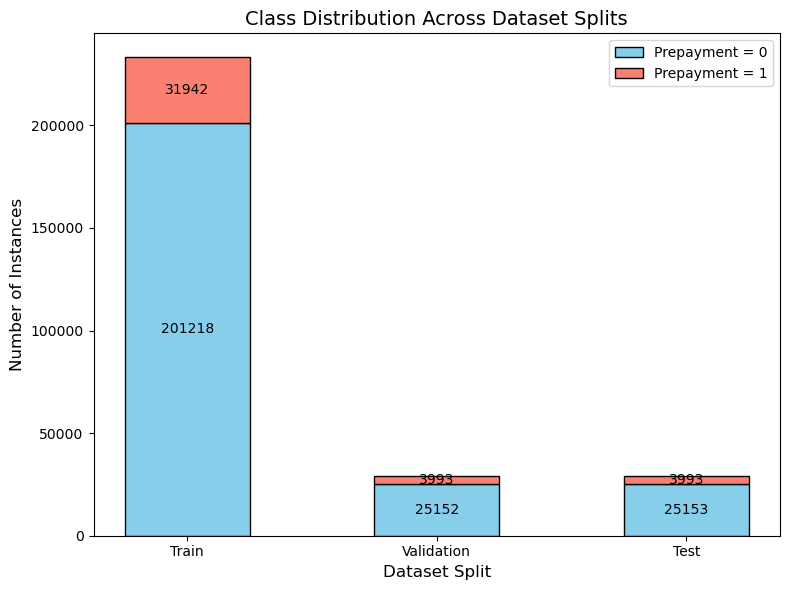

In [72]:
import matplotlib.pyplot as plt

# Data
categories = ['Train', 'Validation', 'Test']
prepayment_0 = [201218, 25152, 25153]  # Instances with Prepayment = 0
prepayment_1 = [31942, 3993, 3993]     # Instances with Prepayment = 1

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.5

# Stacked bar plot
bar_0 = ax.bar(categories, prepayment_0, width, label='Prepayment = 0', color='skyblue', edgecolor='black')
bar_1 = ax.bar(categories, prepayment_1, width, bottom=prepayment_0, label='Prepayment = 1', color='salmon', edgecolor='black')

# Add labels, title, and legend
ax.set_ylabel('Number of Instances', fontsize=12)
ax.set_xlabel('Dataset Split', fontsize=12)
ax.set_title('Class Distribution Across Dataset Splits', fontsize=14)
ax.legend()

# Add annotations
for bar_group in [bar_0, bar_1]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2.,
                f'{int(height)}', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Log transformation

In [73]:
# 0. Daten einlesen
df = pd.read_csv('LoanExport.csv')
# Datenvorverarbeitung
df = data_preprocessing(df)
# Prepayment Column erstellen
df = create_target_variable(df)
df['Prepayment'].value_counts()
# Daten aufteilen
train_df, val_df, test_df = split_data(df)
# Fehlende Werte imputieren
train_df, val_df, test_df = impute_missing_values(train_df, val_df, test_df)
# Kategorische Spalten remappen
train_df, val_df, test_df = encode_categorical_columns(train_df, val_df, test_df)
# Daten skalieren und transformieren wähle eine Art
#transformed_train_df, transformed_val_df, transformed_test_df = standartization(train_df, val_df, test_df)
transformed_train_df, transformed_val_df, transformed_test_df = log_transformation(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = normalization(train_df, val_df, test_df)
# Deffinierung von Features und Target
(X_train, y_train), (X_val, y_val), (X_test, y_test) = define_features_target(transformed_train_df, transformed_val_df, transformed_test_df)
# Punkte entfernen die nicht benötigt werden in den Werten
X_train, y_train, X_val, y_val, X_test, y_test = delete_dot(X_train, y_train, X_val, y_val, X_test, y_test)
# Löscht nicht columns um Modelle nicht zu verfälschen
X_train, X_val, X_test = drop_unnecessary_columns(X_train, X_val, X_test)
# Oversampled die Minoren Klasse
X_trainsmote, y_trainsmote = smote(X_train,y_train)

/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_11232/3502420789.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanExport.csv')


KeyboardInterrupt: 

INFO:__main__:Initialisiere das XGBoost-Modell mit den besten Parametern.
INFO:__main__:Trainiere das Modell...
INFO:__main__:Modelltraining abgeschlossen. Dauer: 1.23 Sekunden


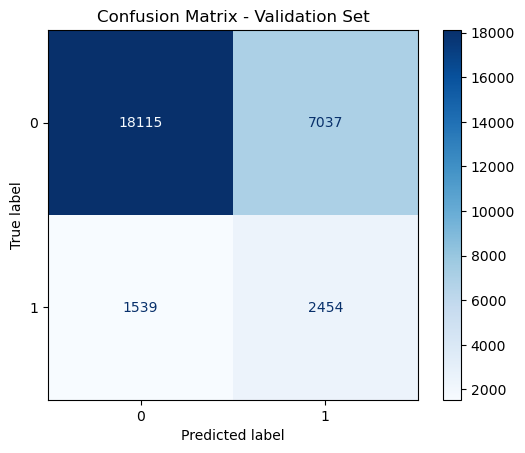

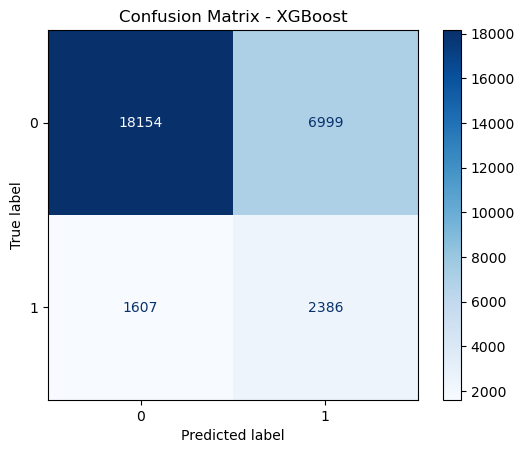

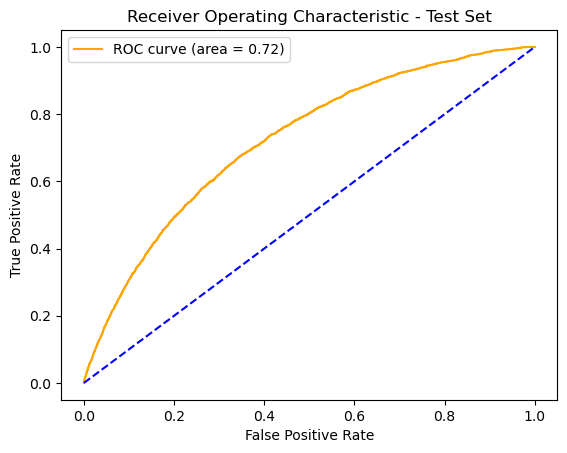

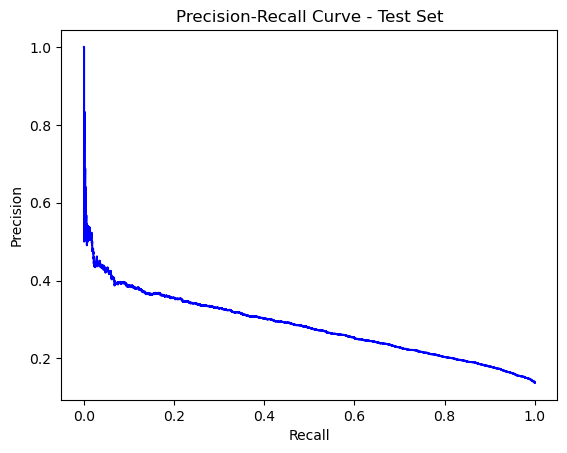

TP= 2386 ; 100
FP= 6999 ; -26
FN= 1607 ; -43
TN= 18154 ; 0
[{'Model': 'XGBoost', 'Result': -12475}]
The Score for the BusinessPointsAspekt is: -12475


In [279]:
#best paremeter
model_xgb = train_best_xgb(X_train, y_train)
evaluate_model_xgb(model_xgb, X_val, y_val, X_test, y_test, threshold=0.534)

Training completed in 3.46 seconds.
Calculating SHAP values...
Generating SHAP Beeswarm plot...


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


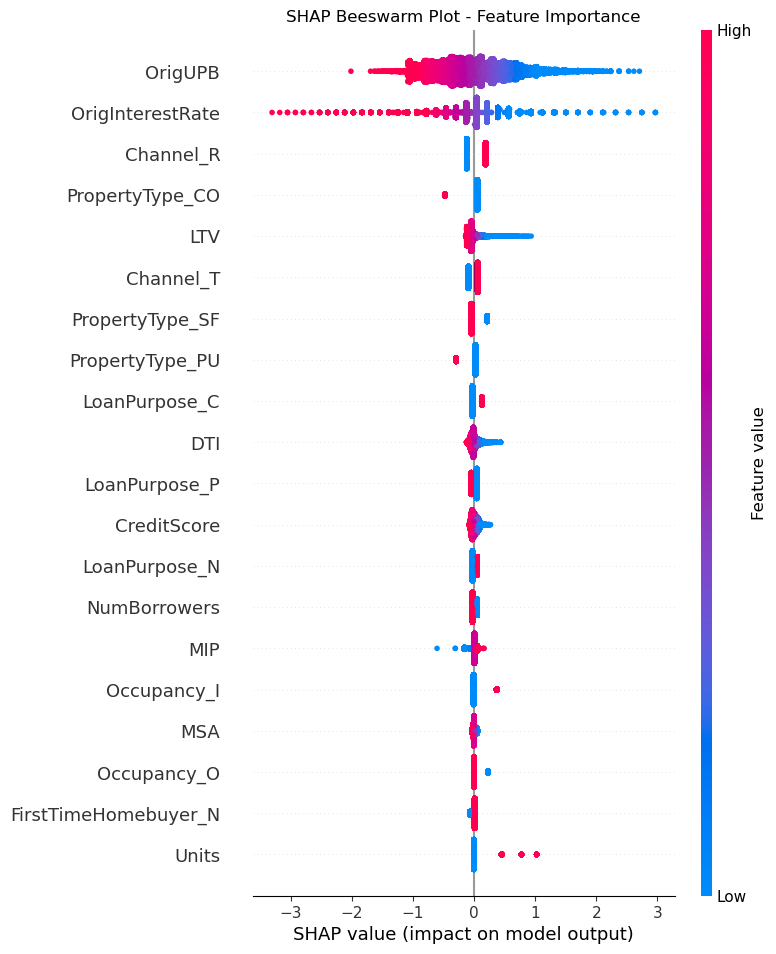

Generating SHAP Bar plot...


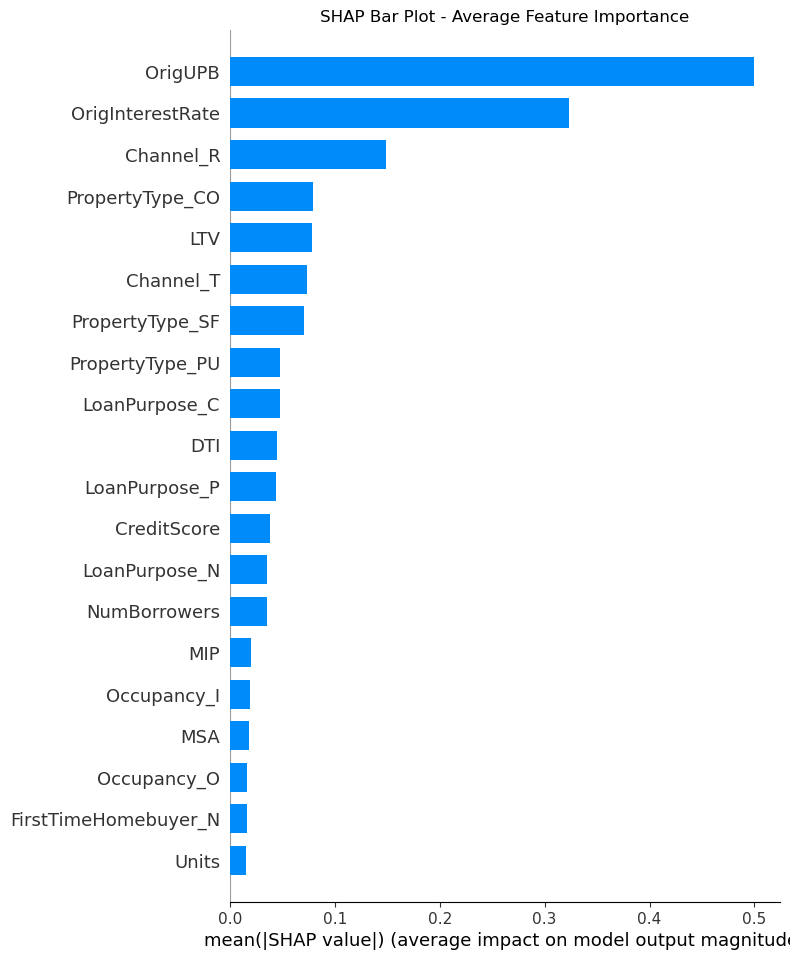

In [310]:
model_lr = train_model_lr(X_train, y_train, X_val)

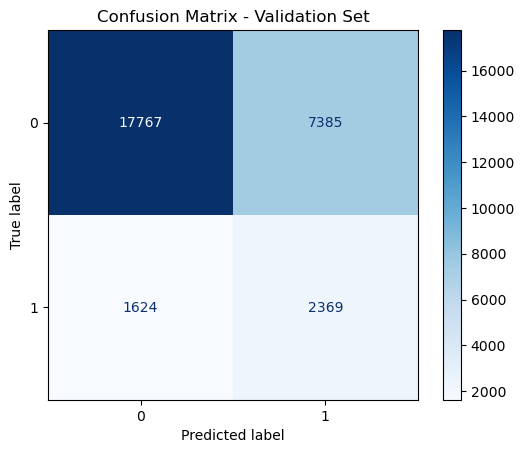

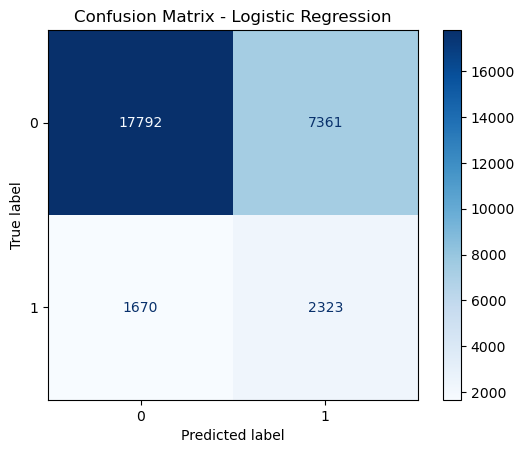

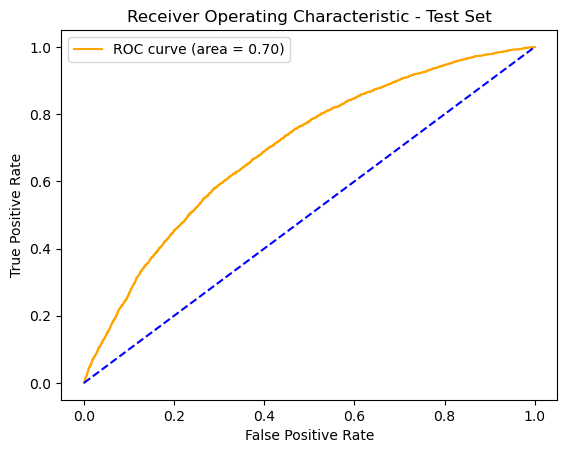

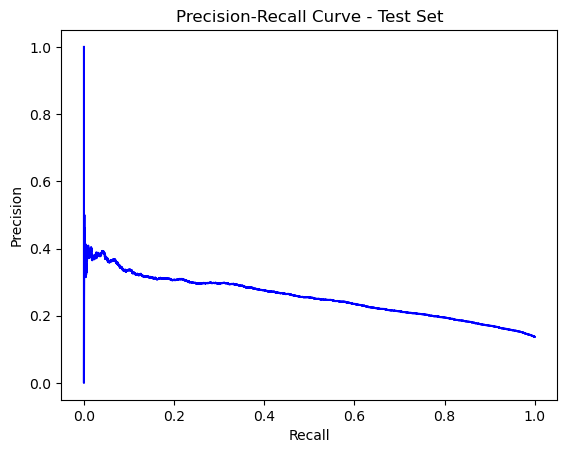

TP= 2323 ; 100
FP= 7361 ; -26
FN= 1670 ; -43
TN= 17792 ; 0
[{'Model': 'XGBoost', 'Result': -12475}, {'Model': 'Logistic Regression (Threshold=0.529)', 'Result': -30896}, {'Model': 'Neural Network (Threshold=0.506)', 'Result': -28114}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30779}, {'Model': '[model_lr, model_rf]_Aggregated', 'Result': -254678}, {'Model': '[model_lr, model_xgb]_Aggregated', 'Result': -254678}, {'Model': '[model_rf, model_xgb]_Aggregated', 'Result': -31455}, {'Model': '[model_lr, model_rf, model_xgb]_Aggregated', 'Result': -254678}, {'Model': '[model_lr, model_rf]_Majority', 'Result': -254678}, {'Model': '[model_lr, model_xgb]_Majority', 'Result': -254678}, {'Model': '[model_rf, model_xgb]_Majority', 'Result': -31455}, {'Model': '[model_lr, model_rf, model_xgb]_Majority', 'Result': -254678}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30753}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30805}, {'Model': 'Random Forest (Threshold=0

In [311]:
evaluate_model_lr(model_lr, X_val, y_val, X_test, y_test, threshold=0.529)

INFO:__main__:Initialisiere das MLPClassifier-Modell mit den besten Parametern.
INFO:__main__:Hyperparameter: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 64, 'learning_rate_init': 0.0001, 'max_iter': 200}
INFO:__main__:SMOTE wurde angewendet, um das Klassenungleichgewicht im Datensatz zu behandeln.
INFO:__main__:Starte Training des Modells...
INFO:__main__:Trainingszeit: 46.84 Sekunden
INFO:__main__:Visualisiere die Verlustkurve (Loss Curve)...


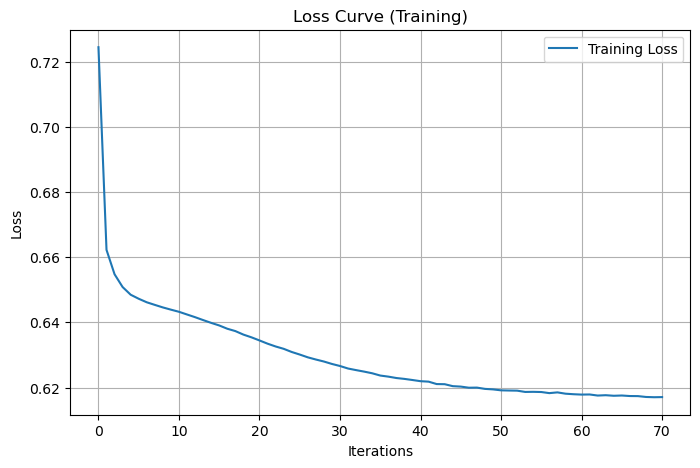

In [282]:
nn_model = train_best_nn(X_trainsmote, y_trainsmote)


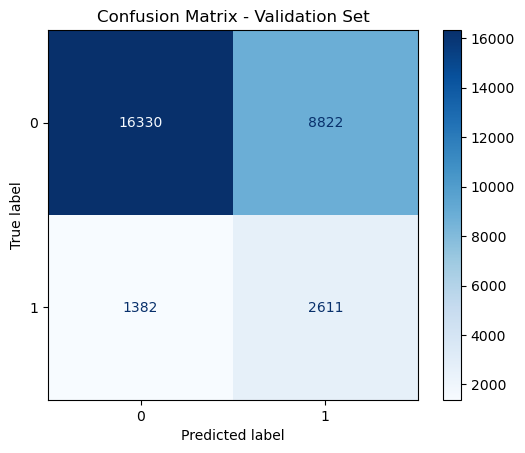

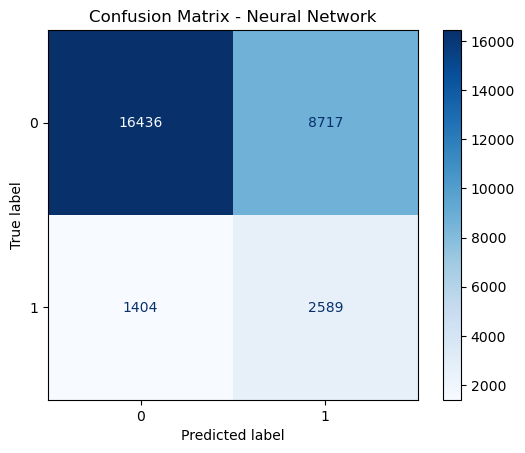

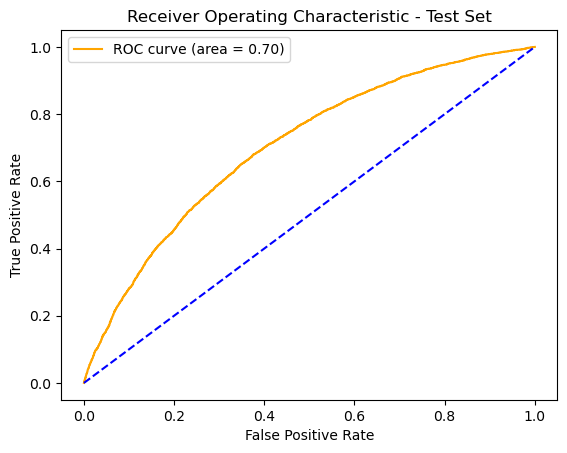

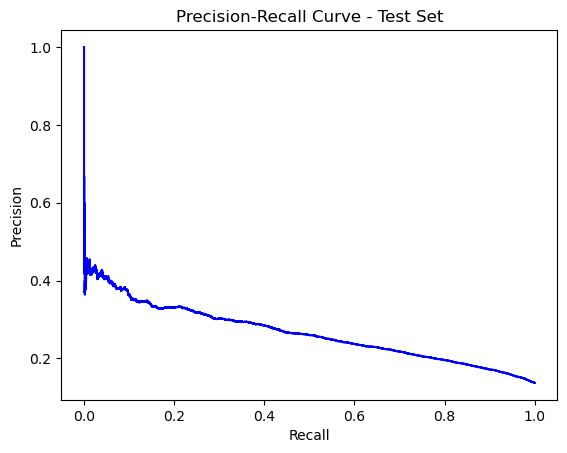

TP= 2589 ; 100
FP= 8717 ; -26
FN= 1404 ; -43
TN= 16436 ; 0
[{'Model': 'XGBoost', 'Result': -12475}, {'Model': 'Logistic Regression (Threshold=0.529)', 'Result': -30896}, {'Model': 'Neural Network (Threshold=0.506)', 'Result': -28114}]
The Score for the BusinessPointsAspekt is: -28114


In [283]:
evaluate_model_nn(nn_model, X_val, y_val, X_test, y_test, threshold=0.506)

In [306]:
# 0. Daten einlesen
df = pd.read_csv('LoanExport.csv')
# Datenvorverarbeitung
df = data_preprocessing(df)
# Prepayment Column erstellen
df = create_target_variable(df)
# Daten aufteilen
train_df, val_df, test_df = split_data(df)
# Fehlende Werte imputieren
train_df, val_df, test_df = impute_missing_values(train_df, val_df, test_df)
# Kategorische Spalten remappen
train_df, val_df, test_df = encode_categorical_columns(train_df, val_df, test_df)
# Daten skalieren und transformieren wähle eine Art
#transformed_train_df, transformed_val_df, transformed_test_df = standartization(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = log_transformation(train_df, val_df, test_df)
#transformed_train_df, transformed_val_df, transformed_test_df = normalization(train_df, val_df, test_df)
# Deffinierung von Features und Target
(X_train, y_train), (X_val, y_val), (X_test, y_test) = define_features_target(train_df, val_df, test_df)
# Punkte entfernen die nicht benötigt werden in den Werten
X_train, y_train, X_val, y_val, X_test, y_test = delete_dot(X_train, y_train, X_val, y_val, X_test, y_test)
# Löscht nicht columns um Modelle nicht zu verfälschen
X_train, X_val, X_test = drop_unnecessary_columns(X_train, X_val, X_test)
# Oversampled die Minoren Klasse
X_trainsmote, y_trainsmote = smote(X_train,y_train)

/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_2155/3294302359.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanExport.csv')


Prepayment
0    251523
1     39928
Name: count, dtype: int64


/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_2155/3915558762.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_2155/3915558762.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val = X_val.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)
/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_2155/3915558762.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = X_test.applymap(lambda x: remove_dot_and_convert(x) if isinstance(x, (str, float, int)) else x)


In [307]:
model_rf = train_best_rf(X_train, y_train)

Training abgeschlossen mit den besten Parametern: {'n_estimators': 100, 'max_depth': 30, 'max_leaf_nodes': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}
Trainingszeit: 7.06 Sekunden


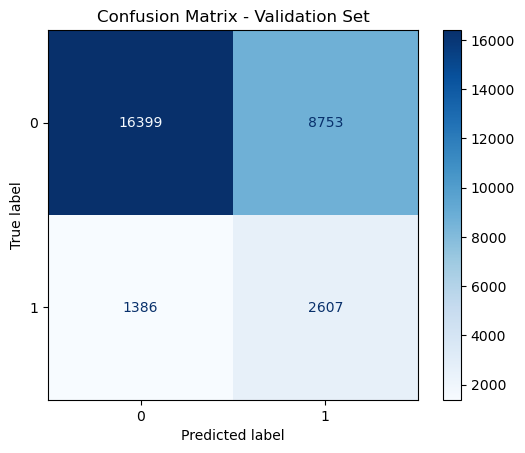

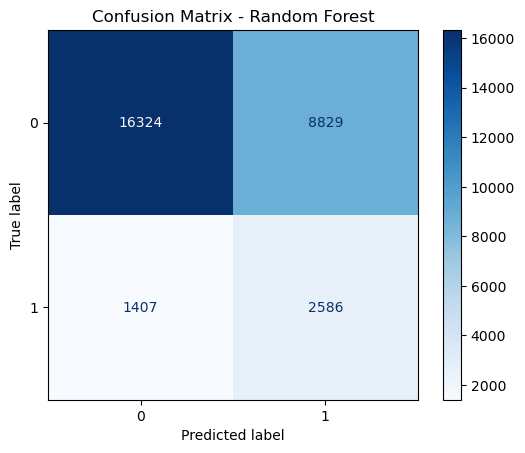

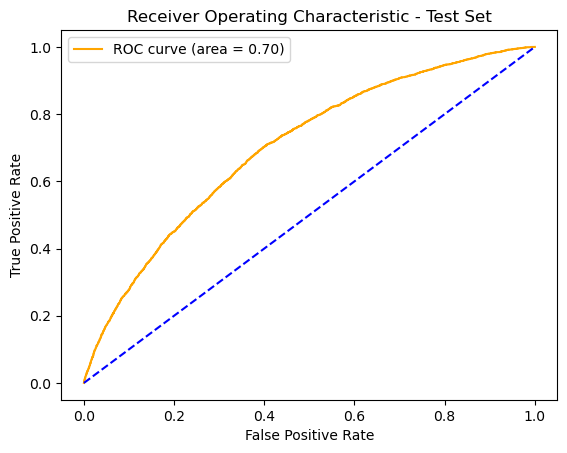

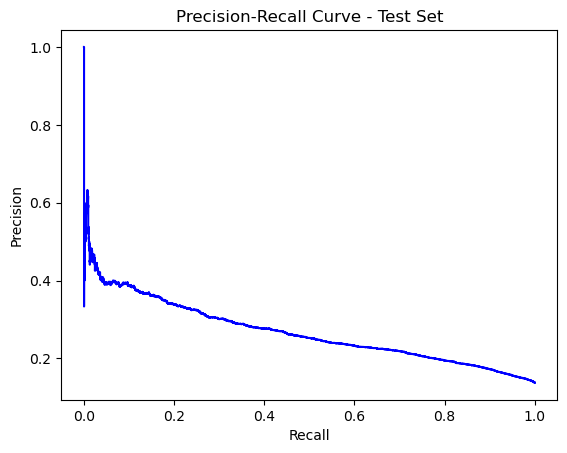

TP= 2586 ; 100
FP= 8829 ; -26
FN= 1407 ; -43
TN= 16324 ; 0
[{'Model': 'XGBoost', 'Result': -12475}, {'Model': 'Logistic Regression (Threshold=0.529)', 'Result': -30896}, {'Model': 'Neural Network (Threshold=0.506)', 'Result': -28114}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30779}, {'Model': '[model_lr, model_rf]_Aggregated', 'Result': -254678}, {'Model': '[model_lr, model_xgb]_Aggregated', 'Result': -254678}, {'Model': '[model_rf, model_xgb]_Aggregated', 'Result': -31455}, {'Model': '[model_lr, model_rf, model_xgb]_Aggregated', 'Result': -254678}, {'Model': '[model_lr, model_rf]_Majority', 'Result': -254678}, {'Model': '[model_lr, model_xgb]_Majority', 'Result': -254678}, {'Model': '[model_rf, model_xgb]_Majority', 'Result': -31455}, {'Model': '[model_lr, model_rf, model_xgb]_Majority', 'Result': -254678}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30753}, {'Model': 'Random Forest (Threshold=0.488)', 'Result': -30805}, {'Model': 'Random Forest (Threshold=0

In [308]:
evaluate_model_rf(model_rf, X_val, y_val, X_test, y_test, threshold=0.5)

## Model Comparison


### Model Comparison ###

╒═══════════════════════════════════════╤════════════════╤══════════════╤══════════╤═══════════════╤═════════════════╤═══════════════╤═══════════╤════════════════╤══════════════╕
│ Model                                 │   val_accuracy │   val_recall │   val_f1 │   val_roc_auc │   test_accuracy │   test_recall │   test_f1 │   test_roc_auc │   train_time │
╞═══════════════════════════════════════╪════════════════╪══════════════╪══════════╪═══════════════╪═════════════════╪═══════════════╪═══════════╪════════════════╪══════════════╡
│ XGBoost (Threshold=0.534)             │         0.7057 │       0.6146 │   0.3640 │        0.7329 │          0.7047 │        0.5975 │    0.3567 │         0.7213 │       1.2300 │
├───────────────────────────────────────┼────────────────┼──────────────┼──────────┼───────────────┼─────────────────┼───────────────┼───────────┼────────────────┼──────────────┤
│ Logistic Regression (Threshold=0.529) │         0.6909 │       0.5933 │   0.

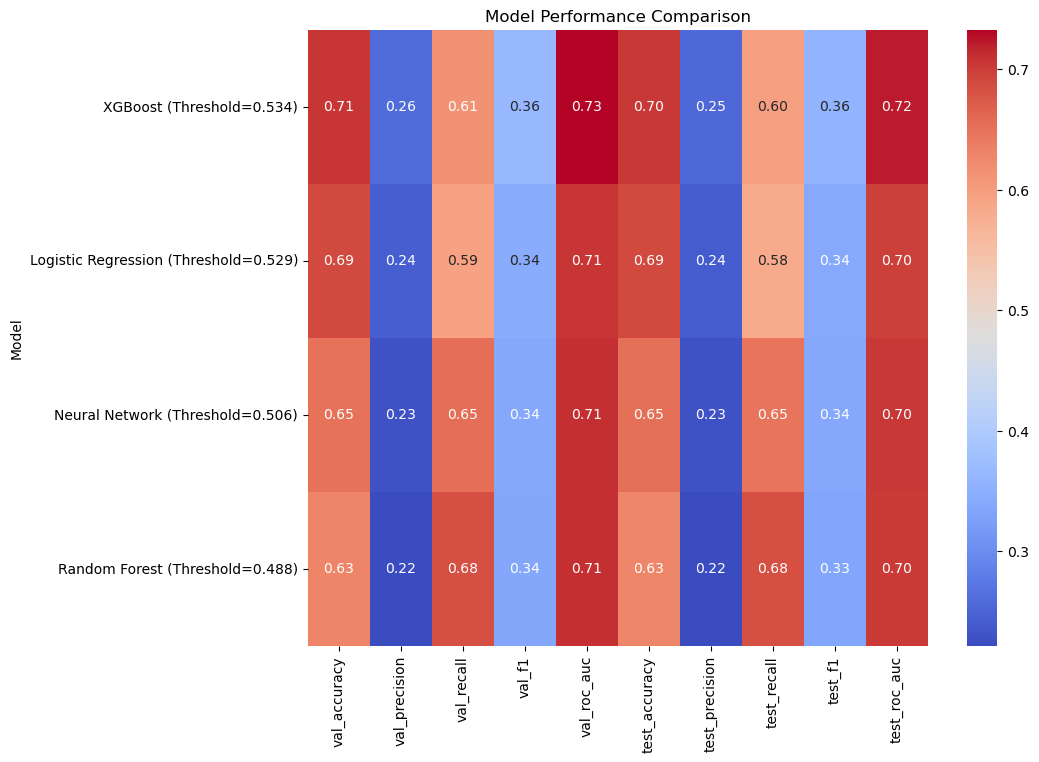

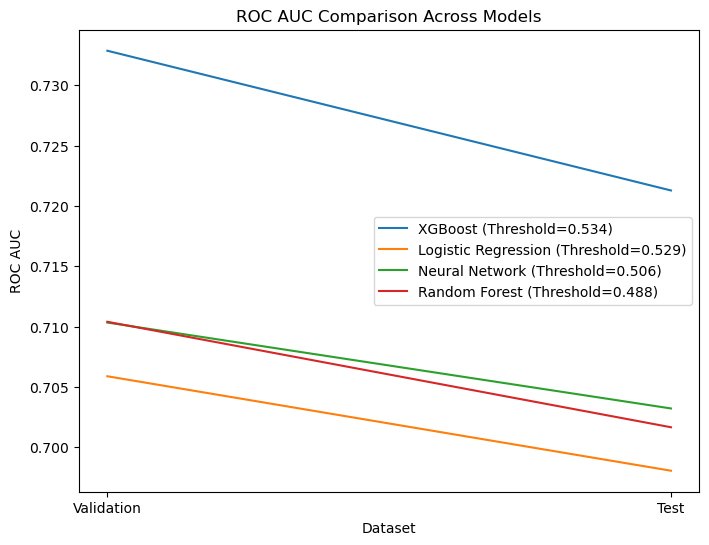

   val_accuracy  val_precision  val_recall    val_f1  val_roc_auc  val_time  \
0      0.705747       0.258561    0.614576  0.363987     0.732863  0.039852   
1      0.690890       0.242875    0.593288  0.344657     0.705888  0.003152   
2      0.649888       0.228374    0.653894  0.338519     0.710339  0.014390   
3      0.629027       0.222286    0.683446  0.335464     0.710403  0.117784   

   test_accuracy  test_precision  test_recall   test_f1  test_roc_auc  \
0       0.704728        0.254235     0.597546  0.356705      0.721283   
1       0.690146        0.239880     0.581768  0.339694      0.698060   
2       0.652748        0.228993     0.648385  0.338453      0.703219   
3       0.627771        0.221572     0.683196  0.334621      0.701662   

   test_time  train_time                                  Model  
0   0.034753    1.229955              XGBoost (Threshold=0.534)  
1   0.002820    2.995615  Logistic Regression (Threshold=0.529)  
2   0.009448   46.835493       Neural Ne

In [287]:
# Vergleich erstellen
results_df, best_model = compare_models_from_results(show_plots=True, metric="test_f1") #set false if you dont want any plots, then just df will be returned / other metric for best model

# Ergebnisse anzeigen
print(results_df)

# Create df with results
results_df.to_csv("model_comparison_results.csv", index=False)

In [288]:
best_model = get_best_model(model_businessresults)


### Business Model Comparison ###

╒═══════════════════════════════════════╤═════════════╕
│ Model                                 │      Result │
╞═══════════════════════════════════════╪═════════════╡
│ XGBoost                               │ -12475.0000 │
├───────────────────────────────────────┼─────────────┤
│ Logistic Regression (Threshold=0.529) │ -30896.0000 │
├───────────────────────────────────────┼─────────────┤
│ Neural Network (Threshold=0.506)      │ -28114.0000 │
├───────────────────────────────────────┼─────────────┤
│ Random Forest (Threshold=0.488)       │ -30779.0000 │
╘═══════════════════════════════════════╧═════════════╛

### Best Business Model ###

╒═════════╤═════════════╕
│ Model   │      Result │
╞═════════╪═════════════╡
│ XGBoost │ -12475.0000 │
╘═════════╧═════════════╛


In [289]:
best_model = get_best_model(model_businessresults)


### Business Model Comparison ###

╒═══════════════════════════════════════╤═════════════╕
│ Model                                 │      Result │
╞═══════════════════════════════════════╪═════════════╡
│ XGBoost                               │ -12475.0000 │
├───────────────────────────────────────┼─────────────┤
│ Logistic Regression (Threshold=0.529) │ -30896.0000 │
├───────────────────────────────────────┼─────────────┤
│ Neural Network (Threshold=0.506)      │ -28114.0000 │
├───────────────────────────────────────┼─────────────┤
│ Random Forest (Threshold=0.488)       │ -30779.0000 │
╘═══════════════════════════════════════╧═════════════╛

### Best Business Model ###

╒═════════╤═════════════╕
│ Model   │      Result │
╞═════════╪═════════════╡
│ XGBoost │ -12475.0000 │
╘═════════╧═════════════╛


In [290]:
#pd = pd.DataFrame(ERROR)

# Sandbox

In [291]:
def aggregate_predictions(models, X_test):
    """
    Aggregiert die Vorhersagen mehrerer Modelle, indem alle Einträge mit Prepayment (1) vereint werden.
    
    Parameter:
        - models: Liste der trainierten Modelle
        - X_test: Testdaten
    
    Rückgabe:
        - aggregated_predictions: Array mit aggregierten Vorhersagen (1 oder 0)
    """
    # Sammle die Vorhersagen jedes Modells
    all_predictions = []

    for model in models:
        # Vorhersagen des Modells (1 = Prepayment)
        preds = model.predict(X_test)
        all_predictions.append(preds)

    # Aggregiere die Vorhersagen (Union der Einträge mit 1)
    aggregated_predictions = np.any(all_predictions, axis=0).astype(int)

    return aggregated_predictions

def evaluate_aggregated_predictions(y_test, aggregated_predictions, model_names):
    """
    Evaluierung der aggregierten Vorhersagen.
    
    Parameter:
        - y_test: Wahre Labels
        - aggregated_predictions: Aggregierte Vorhersagen (1 oder 0)
        - model_names: String mit den Namen der Modelle in der Kombination
    """
    print(f"\n### Evaluation for Combination: {model_names} ###")
    print(classification_report(y_test, aggregated_predictions))
    cm = confusion_matrix(y_test, aggregated_predictions)
    print("Confusion Matrix:\n", cm)

    TN, FP, FN, TP = cm.ravel()

    # Business-Score berechnen
    business_score = calculate_business_score(TP, FP, FN, TN)

    # Ergebnisse speichern
    model_businessresults.append({
        "Model": model_names,
        "Result": business_score
    })

def evaluate_all_combinations_aggregated(models, model_names, X_test, y_test):
    """
    Iteriert durch alle möglichen Kombinationen der Modelle, aggregiert Vorhersagen
    und evaluiert sie.
    
    Parameter:
        - models: Liste der trainierten Modelle
        - model_names: Liste der Namen der Modelle
        - X_test: Testdaten
        - y_test: Wahre Labels
    """
    from itertools import combinations

    # Iteriere durch alle möglichen Kombinationen (mindestens 2 Modelle)
    for r in range(2, len(models) + 1):
        for combination in combinations(zip(models, model_names), r):
            # Extrahiere Modelle und ihre Namen aus der Kombination
            selected_models, selected_names = zip(*combination)

            # Erstelle den Namen für die Kombination
            combination_name = f"[{', '.join(selected_names)}]_Aggregated"

            # Aggregierte Vorhersagen erstellen
            aggregated_preds = aggregate_predictions(selected_models, X_test)

            # Aggregierte Vorhersagen evaluieren
            evaluate_aggregated_predictions(y_test, aggregated_preds, combination_name)

# Modelle und ihre Namen
models = [model_lr, model_rf, model_xgb]
model_names = ["model_lr", "model_rf", "model_xgb"] 

# Evaluierung aller Kombinationen
evaluate_all_combinations_aggregated(models, model_names, X_test, y_test)


### Evaluation for Combination: [model_lr, model_rf]_Aggregated ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 ; -43
TN= 0 ; 0

### Evaluation for Combination: [model_lr, model_xgb]_Aggregated ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 ; -43
TN= 0 ; 0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


### Evaluation for Combination: [model_rf, model_xgb]_Aggregated ###
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     25153
           1       0.23      0.65      0.34      3993

    accuracy                           0.65     29146
   macro avg       0.57      0.65      0.55     29146
weighted avg       0.83      0.65      0.70     29146

Confusion Matrix:
 [[16324  8829]
 [ 1407  2586]]
TP= 2586 ; 100
FP= 8829 ; -26
FN= 1407 ; -43
TN= 16324 ; 0

### Evaluation for Combination: [model_lr, model_rf, model_xgb]_Aggregated ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [292]:
def majority_vote_predictions(models, X_test, threshold_ratio=0.5):
    """
    Aggregiert die Vorhersagen mehrerer Modelle basierend auf der Mehrheit.
    Ein Eintrag wird als Prepayment (1) klassifiziert, wenn die Anzahl der Modelle,
    die 1 vorhersagen, größer oder gleich dem Schwellenwert (threshold_ratio) ist.
    
    Parameter:
        - models: Liste der trainierten Modelle
        - X_test: Testdaten
        - threshold_ratio: Verhältnis, das die Mehrheit bestimmt (Standard: 0.5, also mehr als die Hälfte)
    
    Rückgabe:
        - majority_predictions: Array mit aggregierten Vorhersagen (1 oder 0)
    """
    # Sammle die Vorhersagen jedes Modells
    all_predictions = []

    for model in models:
        # Vorhersagen des Modells (1 = Prepayment)
        preds = model.predict(X_test)
        all_predictions.append(preds)

    # Konvertiere in eine NumPy-Array (Zeilen: Modelle, Spalten: Einträge)
    all_predictions = np.array(all_predictions)

    # Zähle, wie viele Modelle pro Eintrag 1 vorhersagen
    sum_predictions = np.sum(all_predictions, axis=0)

    # Bestimme die Schwelle basierend auf der Anzahl der Modelle
    threshold = int(len(models) * threshold_ratio)

    # Mehrheitsvoting: Nur Einträge, bei denen die Mehrheit 1 sagt, werden als 1 klassifiziert
    majority_predictions = (sum_predictions >= threshold).astype(int)

    return majority_predictions

def evaluate_majority_predictions(y_test, majority_predictions, model_names):
    """
    Evaluierung der Mehrheitsvoting-Vorhersagen.
    
    Parameter:
        - y_test: Wahre Labels
        - majority_predictions: Mehrheitsvoting-Vorhersagen (1 oder 0)
        - model_names: String mit den Namen der Modelle in der Kombination
    """
    print(f"\n### Evaluation for Combination: {model_names} ###")
    print(classification_report(y_test, majority_predictions))
    cm = confusion_matrix(y_test, majority_predictions)
    print("Confusion Matrix:\n", cm)

    TN, FP, FN, TP = cm.ravel()

    # Business-Score berechnen
    business_score = calculate_business_score(TP, FP, FN, TN)

    # Ergebnisse speichern
    model_businessresults.append({
        "Model": model_names,
        "Result": business_score
    })

def evaluate_all_combinations_with_majority_voting(models, model_names, X_test, y_test, threshold_ratio=0.5):
    """
    Iteriert durch alle möglichen Kombinationen der Modelle, führt Mehrheitsvoting durch
    und evaluiert sie.
    
    Parameter:
        - models: Liste der trainierten Modelle
        - model_names: Liste der Namen der Modelle
        - X_test: Testdaten
        - y_test: Wahre Labels
        - threshold_ratio: Verhältnis, das die Mehrheit bestimmt (Standard: 0.5)
    """
    from itertools import combinations

    # Iteriere durch alle möglichen Kombinationen (mindestens 2 Modelle)
    for r in range(2, len(models) + 1):
        for combination in combinations(zip(models, model_names), r):
            # Extrahiere Modelle und ihre Namen aus der Kombination
            selected_models, selected_names = zip(*combination)

            # Erstelle den Namen für die Kombination
            combination_name = f"[{', '.join(selected_names)}]_Majority"

            # Aggregierte Vorhersagen basierend auf Mehrheitsvoting erstellen
            majority_preds = majority_vote_predictions(selected_models, X_test, threshold_ratio)

            # Mehrheitsvoting-Vorhersagen evaluieren
            evaluate_majority_predictions(y_test, majority_preds, combination_name)

# Modelle und ihre Namen
models = [model_lr, model_rf, model_xgb]
model_names = ["model_lr", "model_rf", "model_xgb"] 

# Evaluierung aller Kombinationen mit Mehrheitsvoting
evaluate_all_combinations_with_majority_voting(models, model_names, X_test, y_test, threshold_ratio=0.5)


### Evaluation for Combination: [model_lr, model_rf]_Majority ###


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 ; -43
TN= 0 ; 0

### Evaluation for Combination: [model_lr, model_xgb]_Majority ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 ; -43
TN= 0 ; 0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


### Evaluation for Combination: [model_rf, model_xgb]_Majority ###
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     25153
           1       0.23      0.65      0.34      3993

    accuracy                           0.65     29146
   macro avg       0.57      0.65      0.55     29146
weighted avg       0.83      0.65      0.70     29146

Confusion Matrix:
 [[16324  8829]
 [ 1407  2586]]
TP= 2586 ; 100
FP= 8829 ; -26
FN= 1407 ; -43
TN= 16324 ; 0

### Evaluation for Combination: [model_lr, model_rf, model_xgb]_Majority ###
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25153
           1       0.14      1.00      0.24      3993

    accuracy                           0.14     29146
   macro avg       0.07      0.50      0.12     29146
weighted avg       0.02      0.14      0.03     29146

Confusion Matrix:
 [[    0 25153]
 [    0  3993]]
TP= 3993 ; 100
FP= 25153 ; -26
FN= 0 ; -4

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [293]:
best_model = get_best_model(model_businessresults)


### Business Model Comparison ###

╒════════════════════════════════════════════╤══════════════╕
│ Model                                      │       Result │
╞════════════════════════════════════════════╪══════════════╡
│ XGBoost                                    │  -12475.0000 │
├────────────────────────────────────────────┼──────────────┤
│ Logistic Regression (Threshold=0.529)      │  -30896.0000 │
├────────────────────────────────────────────┼──────────────┤
│ Neural Network (Threshold=0.506)           │  -28114.0000 │
├────────────────────────────────────────────┼──────────────┤
│ Random Forest (Threshold=0.488)            │  -30779.0000 │
├────────────────────────────────────────────┼──────────────┤
│ [model_lr, model_rf]_Aggregated            │ -254678.0000 │
├────────────────────────────────────────────┼──────────────┤
│ [model_lr, model_xgb]_Aggregated           │ -254678.0000 │
├────────────────────────────────────────────┼──────────────┤
│ [model_rf, model_xgb]_Aggregated

/var/folders/n5/42y_fzkn0vn31wdsf69k5whh0000gn/T/ipykernel_2155/3025119177.py:73: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LoanExport.csv')


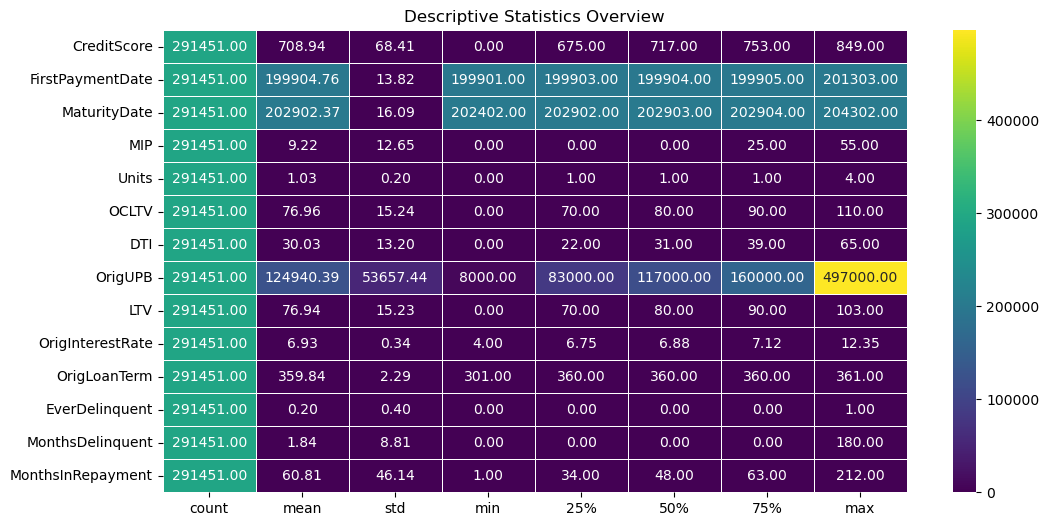

ValueError: could not convert string to float: 'N'

In [294]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Plot-Funktionen
def plot_descriptive_statistics(df):
    desc_stats = df.describe().T
    plt.figure(figsize=(12, 6))
    sns.heatmap(desc_stats, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
    plt.title("Descriptive Statistics Overview")
    plt.show()

def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(14, 7))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)
    plt.title("Correlation Matrix")
    plt.show()

def plot_target_distribution(df, target_column='Prepayment'):
    target_counts = df[target_column].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
    plt.title("Distribution of Target Variable")
    plt.xlabel(target_column)
    plt.ylabel("Count")
    plt.show()

def plot_distribution_before_after_transformation(original_df, transformed_df, columns):
    for col in columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(original_df[col], kde=True, color="blue", label=f"Original: {col}")
        sns.histplot(transformed_df[col], kde=True, color="green", label=f"Transformed: {col}")
        plt.title(f"Distribution of {col} (Before and After Transformation)")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

def plot_class_distribution_before_after_smote(y_before, y_after):
    # Before SMOTE
    plt.figure(figsize=(8, 6))
    sns.barplot(x=y_before.value_counts().index, y=y_before.value_counts().values, palette="viridis")
    plt.title("Class Distribution Before SMOTE")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.show()

    # After SMOTE
    plt.figure(figsize=(8, 6))
    sns.barplot(x=y_after.value_counts().index, y=y_after.value_counts().values, palette="viridis")
    plt.title("Class Distribution After SMOTE")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.show()

def plot_pca_after_smote(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", alpha=0.6)
    plt.title("PCA Visualization After SMOTE")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes")
    plt.show()

# Pipeline-Ablauf mit Plots
def run_pipeline():
    # 0. Daten einlesen
    df = pd.read_csv('LoanExport.csv')
    
    # Deskriptive Statistik und Korrelationsmatrix
    plot_descriptive_statistics(df)
    plot_correlation_matrix(df)

    # 1. Datenvorverarbeitung
    df = data_preprocessing(df)
    
    # 2. Prepayment Column erstellen
    df = create_target_variable(df)
    
    # Zielvariable (Prepayment-Verteilung)
    plot_target_distribution(df, target_column='Prepayment')

    # 3. Daten aufteilen
    train_df, val_df, test_df = split_data(df)

    # 4. Fehlende Werte imputieren
    train_df, val_df, test_df = impute_missing_values(train_df, val_df, test_df)

    # 5. Kategorische Spalten remappen
    train_df, val_df, test_df = encode_categorical_columns(train_df, val_df, test_df)

    # 6. Daten skalieren und transformieren
    transformed_train_df, transformed_val_df, transformed_test_df = log_transformation(train_df, val_df, test_df)

    # Verteilung vor und nach Transformation
    numerical_columns = ['CreditScore', 'LTV', 'OrigUPB']  # Beispielspalten
    plot_distribution_before_after_transformation(train_df, transformed_train_df, numerical_columns)

    # 7. Features und Ziel definieren
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = define_features_target(
        transformed_train_df, transformed_val_df, transformed_test_df
    )

    # 8. Oversampling mit SMOTE
    smote = SMOTE(random_state=42)
    X_trainsmote, y_trainsmote = smote.fit_resample(X_train, y_train)

    # Klassenverteilung vor und nach SMOTE
    plot_class_distribution_before_after_smote(y_train, y_trainsmote)

    # PCA-Visualisierung nach SMOTE
    plot_pca_after_smote(X_trainsmote, y_trainsmote)

# Pipeline ausführen
run_pipeline()